<a href="https://colab.research.google.com/github/Saurav-31/Colab_notebooks_DL/blob/main/VIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Multi Head Self attention** 

*   We have 8 attention heads 
*   3 matrices (Q, K, V) for each attention head. Each matrix is of size (768, 768/nheads) = (768, 96)
*  Stack all matrices for all attention heads (8, 3, 768, 96)  
*  Reshape into dimension (768, 2304) 
*  This is same as Linear layer with weight matrix of same shape 
*  nn.Linear(dim, dim * 3)








In [33]:
from torch import nn

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        print(self.qkv(x).shape)
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        print(qkv.shape)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)
        print(q.shape, k.shape, v.shape)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [34]:
att = Attention(768)
x = torch.FloatTensor(1,197,768).fill_(1)
att(x).shape

torch.Size([1, 197, 2304])
torch.Size([3, 1, 8, 197, 96])
torch.Size([1, 8, 197, 96]) torch.Size([1, 8, 197, 96]) torch.Size([1, 8, 197, 96])


torch.Size([1, 197, 768])

# ***Encoder Block***

* Layer Normalization (LN) and Residual connection  
* Multi-head self attention (MSA)
* Multi layer perceptron (MLP)

In [32]:
class Encoder(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

# ***Vision Transformer***

* Patch Embedding: `nn.Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))`
* Class Token Embedding:  `nn.Parameter(torch.zeros(1, 1, embed_dim))`
* Positional Encoding: `nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))`
* Sequence of Encoders
* MLP Classifier Head  

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=True, qk_scale=None, representation_size=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0., hybrid_backbone=None, norm_layer=None):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)

        if hybrid_backbone is not None:
            self.patch_embed = HybridEmbed(
                hybrid_backbone, img_size=img_size, in_chans=in_chans, embed_dim=embed_dim)
        else:
            self.patch_embed = PatchEmbed(
                img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # Representation layer
        if representation_size:
            self.num_features = representation_size
            self.pre_logits = nn.Sequential(OrderedDict([
                ('fc', nn.Linear(embed_dim, representation_size)),
                ('act', nn.Tanh())
            ]))
        else:
            self.pre_logits = nn.Identity()

        # Classifier head
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)[:, 0]
        x = self.pre_logits(x)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

# **Inference on ViT Model**

In [ ]:
 ! pip install vit_pytorch 
 ! pip install timm

import urllib
import json
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch 
import timm
from vit_pytorch import ViT
import cv2

In [ ]:
model_names = timm.list_models('*vit*')
model_names

['vit_base_patch16_224',
 'vit_base_patch16_384',
 'vit_base_patch32_384',
 'vit_base_resnet26d_224',
 'vit_base_resnet50d_224',
 'vit_huge_patch16_224',
 'vit_huge_patch32_384',
 'vit_large_patch16_224',
 'vit_large_patch16_384',
 'vit_large_patch32_384',
 'vit_small_patch16_224',
 'vit_small_resnet26d_224',
 'vit_small_resnet50d_s3_224']

In [4]:
model = timm.create_model(model_name='vit_base_patch16_224', pretrained=True)
# model = timm.create_model(model_name='vit_base_resnet50d_224', pretrained=True)

model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (

In [5]:
! wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

class_idx = json.load(open("imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

--2021-02-20 19:36:59--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.229.125
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.229.125|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K   193KB/s    in 0.2s    

2021-02-20 19:37:00 (193 KB/s) - ‘imagenet_class_index.json’ saved [35363/35363]



In [7]:
# imgname = "https://www.autocar.co.uk/sites/autocar.co.uk/files/styles/gallery_slide/public/images/car-reviews/first-drives/legacy/porsche_911_carrera_s_manual_tracking.jpg"
imgname = "https://github.com/pytorch/hub/raw/master/images/dog.jpg"

url, filename = (imgname, "dog.jpg")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

input_image = Image.open(filename)
# plt.imshow(np.array(input_image))

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

Text(0.5, 1.0, 'Samoyed')

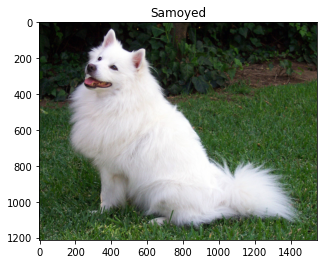

In [8]:
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)

plt.imshow(np.array(input_image))
plt.title(idx2label[output.argmax()])

torch.Size([1, 196, 768])


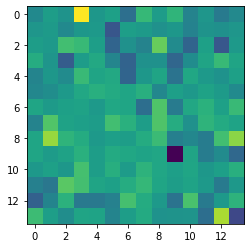

In [9]:
patch_embeds = model.patch_embed(input_batch)
print(patch_embeds.size())
fm0 = patch_embeds[0][:,1]
plt.imshow(fm0.reshape(14,14).detach().numpy())

torch.Size([1, 1, 768])
torch.Size([1, 197, 768])


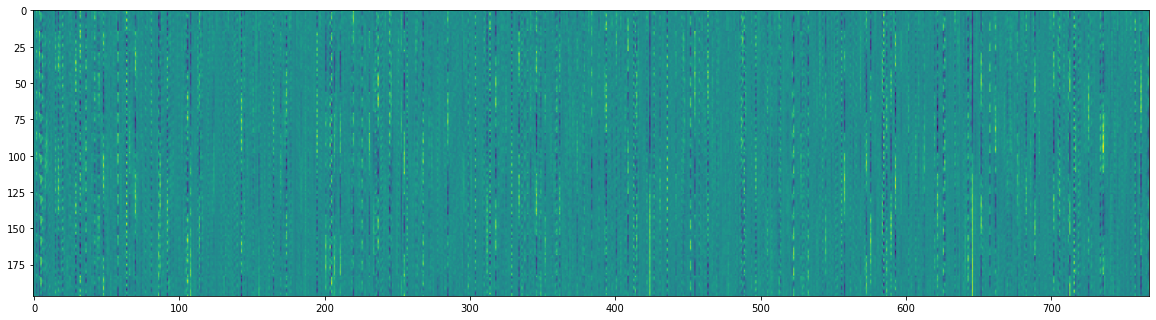

In [10]:
print(model.cls_token.size())
print(model.pos_embed.size())
fig = plt.figure(0, (20,20))
plt.imshow(model.pos_embed[0].detach().numpy())

In [11]:
def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        print("Step 1: Mapping to a latent vector Space {}-d, Output Size: {}".format(x.size(2), x.size()))

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        print("Step 2: class token embedding dim: {}".format(cls_tokens.size()))
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        print("Step 3: Positional encoding is added. Output Size: {}".format(x.size()))

        for blk in self.blocks:
            x = blk(x)
            
        print("Step 4: Transformer Encoder Output Size:{}".format(x.size()))
        # _, axs = plt.subplots(4, 4, figsize=(15, 15))
        # axs = axs.flatten()
        # for i, ax in enumerate(axs):
        #     ax.imshow(cv2.resize(x[0][1:,i].reshape(14,14).detach().numpy(), (224,224)))

        # plt.show()

        x = self.norm(x)[:, 0]
        x = torch.nn.Identity()(x)
        return x

def forward(self, x):
    x = self.forward_features(x)
    x = self.head(x)
    return x

out = forward_features(model, input_batch)
out = idx2label[forward(model, input_batch).argmax()]
out

Step 1: Mapping to a latent vector Space 768-d, Output Size: torch.Size([1, 196, 768])
Step 2: class token embedding dim: torch.Size([1, 1, 768])
Step 3: Positional encoding is added. Output Size: torch.Size([1, 197, 768])
Step 4: Transformer Encoder Output Size:torch.Size([1, 197, 768])


'Samoyed'

In [ ]:
keys = ['qkv', 'attn_drop', 'proj', 'proj_drop']
for i, params in enumerate(list(model.blocks[0].attn.parameters())):
  print(model.blocks[0].attn._modules[keys], params.size())

Linear(in_features=768, out_features=2304, bias=True) torch.Size([2304, 768])
Dropout(p=0.0, inplace=False) torch.Size([2304])
Linear(in_features=768, out_features=768, bias=True) torch.Size([768, 768])
Dropout(p=0.0, inplace=False) torch.Size([768])
